In [1]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Rescaling, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt


tf.random.set_seed(42)
np.random.seed(42)

In [2]:
!gdown 1BXWSdWwE-QHHt36mlU4YKhVWVSUC2eKA > /dev/null 2>&1
!unzip -o dog_maf.zip > /dev/null 2>&1

Загрузите данные так, как это было показано в видеоуроках или любым другим известным вам способом.

Проведите разбиение на тренировочные и тестовые данные.

Реализуйте функцию, в которой вы будете определять архитектуру полносвязной модели нейронной сети без использования слоев свёртки. Функция должна возвращать скомпилированную модель и иметь названия fcc_nn(fully-connected_neural_network). Обучите модель нейронной сети, измеряя точность на каждой эпохе с помощью тестовой выборки. 

Постройте график зависимости ошибки и точности полносвязной нейронной сети в зависимости от эпох.

Реализуйте функцию, в которой вы будете определять архитектуру полносвязной модели нейронной сети, с использованием слоев свёртки, регуляризации, препроцессинга изображений(Rescaling). Функция должна возвращать скомпилированную модель и иметь названия conv_nn(convolutional_neural_network). Обучите модель нейронной сети, измеряя точность на каждой эпохе с помощью тестовой выборки. 

Постройте график зависимости ошибки и точности свёрточной нейронной сети в зависимости от эпох.

Напишите вывод о том, при какой архитектуре нейронной сети качество получилось лучше и почему. Также укажите в выводе, какие методы препроцессинга, регуляризации или гиперпараметры дали наибольший прирост к точности.

Надеюсь, теперь вы с легкостью будете отличать маффин от чихуахуа!

In [3]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  r'train',
  validation_split=0.2,
  subset='both',
  seed=123,
  image_size=(128, 128),
  batch_size=128)
test_ds = tf.keras.utils.image_dataset_from_directory(
  r'test',
  seed=123,
  image_size=(128, 128),
  batch_size=128)

Found 4733 files belonging to 2 classes.
Using 3787 files for training.
Using 946 files for validation.
Found 1184 files belonging to 2 classes.


In [4]:
def make_graph(history):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  plt.plot(range(1, len(accuracy) + 1), accuracy, label='Training Accuracy')
  plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [5]:
save_best_weights = ModelCheckpoint(filepath='./best_weights.h5',
                                    save_weights_only=True,
                                    monitor='accuracy',
                                    mode='max',
                                    save_best_only=True)

Измеряю точность на валидационной выборке на каждой эпохе, а затем финальную на тестовой

In [6]:
def fcc_nn():
    model = Sequential()
    model.add(Flatten(input_shape=(128, 128, 3)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [7]:
model = fcc_nn()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[save_best_weights]
    )

Epoch 1/10
30/30 [==============================] - 20s 389ms/step - loss: 1506.7074 - accuracy: 0.5445 - val_loss: 526.2661 - val_accuracy: 0.5042
Epoch 2/10
30/30 [==============================] - 14s 386ms/step - loss: 303.5297 - accuracy: 0.6052 - val_loss: 208.5217 - val_accuracy: 0.5592
Epoch 3/10
30/30 [==============================] - 16s 419ms/step - loss: 744.1789 - accuracy: 0.5329 - val_loss: 1512.5366 - val_accuracy: 0.5243
Epoch 4/10
30/30 [==============================] - 16s 440ms/step - loss: 457.8857 - accuracy: 0.5997 - val_loss: 162.6026 - val_accuracy: 0.7019
Epoch 5/10
30/30 [==============================] - 14s 387ms/step - loss: 196.1772 - accuracy: 0.6675 - val_loss: 276.7204 - val_accuracy: 0.5455
Epoch 6/10
30/30 [==============================] - 14s 329ms/step - loss: 152.1086 - accuracy: 0.6945 - val_loss: 69.0283 - val_accuracy: 0.7780
Epoch 7/10
30/30 [==============================] - 14s 329ms/step - loss: 68.7592 - accuracy: 0.7550 - val_loss: 50.

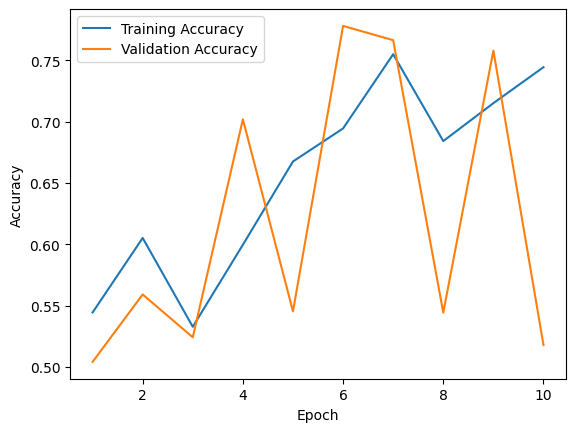

In [8]:
make_graph(history)

In [9]:
model_with_best_weights = fcc_nn()
model_with_best_weights.build((None, 128, 128, 3))
model_with_best_weights.load_weights('./best_weights.h5')
model_with_best_weights.evaluate(test_ds)

10/10 [==============================] - 5s 25ms/step - loss: 53.2832 - accuracy: 0.7703


[53.28318786621094, 0.7702702879905701]

Результат модели на тестовой выборке без использования сверток не удовлетворяет требованиям тренд обучения не устойчивый.

In [14]:
def conv_nn():
  model = Sequential()
  model.add(Rescaling(1./255))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(2, activation='softmax'))

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [11]:
model = conv_nn()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[save_best_weights]
    )

Epoch 1/10
30/30 [==============================] - 31s 655ms/step - loss: 1.3073 - accuracy: 0.5363 - val_loss: 0.6894 - val_accuracy: 0.5243
Epoch 2/10
30/30 [==============================] - 16s 420ms/step - loss: 0.6313 - accuracy: 0.6430 - val_loss: 0.5548 - val_accuracy: 0.7230
Epoch 3/10
30/30 [==============================] - 16s 435ms/step - loss: 0.4419 - accuracy: 0.8059 - val_loss: 0.3813 - val_accuracy: 0.8404
Epoch 4/10
30/30 [==============================] - 16s 385ms/step - loss: 0.3132 - accuracy: 0.8661 - val_loss: 0.3519 - val_accuracy: 0.8467
Epoch 5/10
30/30 [==============================] - 17s 432ms/step - loss: 0.2303 - accuracy: 0.9110 - val_loss: 0.3334 - val_accuracy: 0.8584
Epoch 6/10
30/30 [==============================] - 17s 471ms/step - loss: 0.1518 - accuracy: 0.9477 - val_loss: 0.3605 - val_accuracy: 0.8679
Epoch 7/10
30/30 [==============================] - 17s 458ms/step - loss: 0.1034 - accuracy: 0.9617 - val_loss: 0.4086 - val_accuracy: 0.8531

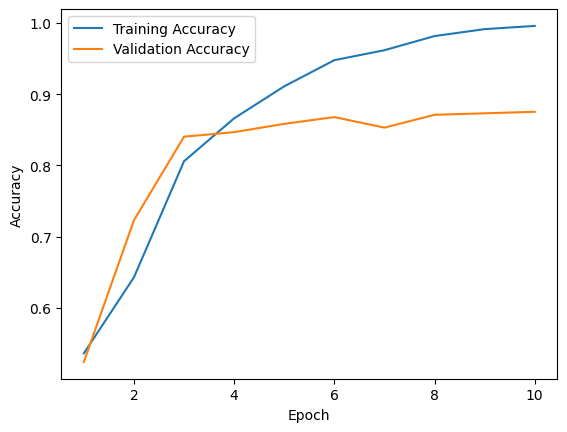

In [12]:
make_graph(history)

In [15]:
model_with_best_weights = conv_nn()
model_with_best_weights.build((None, 128, 128, 3))
model_with_best_weights.load_weights('./best_weights.h5')
model_with_best_weights.evaluate(test_ds)

10/10 [==============================] - 4s 70ms/step - loss: 0.6437 - accuracy: 0.8573


[0.6437209248542786, 0.8572635054588318]

Сверточная модель удовлетворяет заявленным требования, но дает пограничный результат, это связано с высокой сложностью модели.

In [20]:
def conv_nn():
  model = Sequential()
  model.add(Rescaling(1./255))
  model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(2, activation='softmax'))

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [21]:
model = conv_nn()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[save_best_weights]
    )

Epoch 1/10
30/30 [==============================] - 18s 432ms/step - loss: 0.7144 - accuracy: 0.6768 - val_loss: 0.4218 - val_accuracy: 0.7960
Epoch 2/10
30/30 [==============================] - 15s 413ms/step - loss: 0.3947 - accuracy: 0.8284 - val_loss: 0.3434 - val_accuracy: 0.8531
Epoch 3/10
30/30 [==============================] - 15s 408ms/step - loss: 0.3315 - accuracy: 0.8571 - val_loss: 0.3515 - val_accuracy: 0.8562
Epoch 4/10
30/30 [==============================] - 15s 369ms/step - loss: 0.2527 - accuracy: 0.8960 - val_loss: 0.3383 - val_accuracy: 0.8615
Epoch 5/10
30/30 [==============================] - 16s 375ms/step - loss: 0.2111 - accuracy: 0.9160 - val_loss: 0.2974 - val_accuracy: 0.8805
Epoch 6/10
30/30 [==============================] - 17s 446ms/step - loss: 0.1319 - accuracy: 0.9551 - val_loss: 0.3182 - val_accuracy: 0.8795
Epoch 7/10
30/30 [==============================] - 15s 417ms/step - loss: 0.1108 - accuracy: 0.9614 - val_loss: 0.3169 - val_accuracy: 0.8763

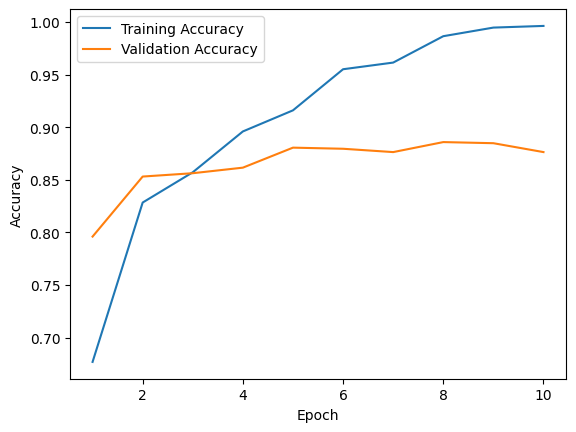

In [22]:
make_graph(history)

In [23]:
model_with_best_weights = conv_nn()
model_with_best_weights.build((None, 128, 128, 3))
model_with_best_weights.load_weights('./best_weights.h5')
model_with_best_weights.evaluate(test_ds)

10/10 [==============================] - 7s 49ms/step - loss: 0.4860 - accuracy: 0.8758


[0.4859805107116699, 0.8758445978164673]

Уменьшив количество фильтров сверток удалось повысить обобщающую способность модели

**Вывод:** результат модели на тестовой выборке при использовании сверток и макс пулинга удовлетворяет требованиям. Имеется устойчивый тренд обучения. Одним из факторов регуляризации помимо дропаутов, батч нормализаций, макс пулингов и др. является количество свертовочных фильтров, которые влияют на сложность модели (если так можно выразиться)